In [19]:
# this notebook plots the histogram: nuclei count vs smFISH detected

In [20]:
# want to see the images inline
%matplotlib inline

# imports
# general 
import os
import glob
from functools import reduce
import re
import csv as csv
# scientific 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, datasets
from scipy.stats import norm, gamma
from scipy.optimize import curve_fit
from scipy import special

import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [21]:
# function for loading one data-set
def load_data(file_path, skiprows_=0):
    data = np.loadtxt(file_path, delimiter = '\t', skiprows=skiprows_)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
    if (len(data.shape) < 2):
        data = data[None, :]
    if (data.shape[1] == 0):
        I = np.array([0])
    else:
        I = data[:, -1]
    return I

In [22]:
# possible labels 
stain = ['DPY-23_EX', 'MDH-1', 'WDR-5.2', 'DPY-23_INT']
stage = 'E' # only embryos
comment = '' # only empty ones

In [23]:
# important indices
stain_columns = ['C0_stain', 'C1_stain', 'C2_stain', 'C3_stain', 'C4_stain']
type_columns = ['C0_type', 'C1_type', 'C2_type', 'C3_type', 'C4_type']
smfish_columns = ['#C0_smfish', '#C1_smfish', '#C2_smfish', '#C3_smfish', '#C4_smfish']
nuclei_column = ['#nuclei']
stain_prefix = np.array([['C1-', 'C2-', 'C3-', 'C4-', 'C5-']])
ext = '.csv'
filename_column = 'new filename'

In [24]:
# some folder magic 
# folder = '/Volumes/1TB/2018-05-15-12-30-27-SEA12-full-stack/' # folder contains z-corrected spots 
folder = '/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-08-23-11-28-45-SEA-12-all-results-together/'

In [25]:
# read the db and parse images that we want to process
df = pd.read_csv(folder + "smFISH-database/N2-Table 1 copy.csv", sep=',', na_values=['']);
df.head()

,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
0,N2,1.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-001.nd2,N2_1,NaN,NaN,NaN,NaN,NaN,NaN
1,N2,2.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,11/17/2016,2016-11-17_N2-DPY-23-002.nd2,N2_2,NaN,NaN,NaN,NaN,NaN,NaN
2,N2,3.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,"dirt, not complete",11/17/2016,2016-11-17_N2-DPY-23-003.nd2,N2_3,NaN,NaN,NaN,NaN,NaN,NaN
3,N2,4.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,11/17/2016,2016-11-17_N2-DPY-23-004.nd2,N2_4,NaN,NaN,NaN,NaN,NaN,NaN
4,N2,5.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-005.nd2,N2_5,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# grabbing real nuclei stage from Ella
df_ella = pd.read_csv(folder + "smFISH-database/ella_embryo_spreadsheet.csv", sep=',', na_values=['']);
df_ella.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1,image,#channels,c0,c1,c2,c3,...,c2_lambda,c3_lambda,c4_lambda,original filename,new filename,DAPI channel,mask maker,crop location,stage counter,stage mean
0,0,0,0,0,N2_8_50.tif,5.0,Cy5,mCherryFISH_ANndor,GoldFISH_Andor,GFP_Andor,...,566.0,507.0,461.0,2017-10-25_N2_DPY23-ex-int_mdh1_008_(series 05...,N2_870,4,RF,NaN,NaN,NaN
1,1,1,1,1,SEA12_149_42.tif,5.0,Cy5_FISH_ANDOR,mCherry_FISH_Andor,GoldFISH_ANDOR,DAPI_ANDOR,...,570.0,0.0,0.0,2017-05-28_SEA12_dpy23_wdr52_mdh1_006_(series ...,SEA-12_277,3,L,NaN,2.0,3.0
2,2,2,2,2,SEA12_43_1.tif,3.0,Cy5_FISH_ANDOR,DAPI_ANDOR,GFP_ANDOR,NaN,...,0.0,NaN,NaN,2017-04-04_SEA12_DPY23_028_(series 001).nd2,SEA-12_144,1,L,NaN,NaN,NaN
3,3,3,3,3,N2_130_1.tif,5.0,Cy5,mCherryFISH_ANndor,GoldFISH_Andor,GFP_Andor,...,566.0,507.0,461.0,2017-10-25_N2_DPY23-ex-int_mdh1_007_08.nd2,N2_871,4,RF,310 620 383 577,1.0,1.0
4,4,4,4,4,MK4_2_18.tif,5.0,Cy5,mCherryFISH_ANndor,GoldFISH_Andor,GFP_Andor,...,566.0,507.0,461.0,2017-10-25_MK4_DPY23-ex-int_mdh1_004_(series 0...,MK4_1,4,RF,296 625 313 547,1.0,1.0


In [27]:
# field you are looking for is stage counter ''
df_ella_length = df_ella['new filename'].size
df_length = df['new filename'].size

for row in range(0, df_ella_length):
    if (not np.isnan(df_ella['stage counter'][row])):
        print (row, df_ella['new filename'][row])
        for to_set_row in range(0, df_length):
            if (df['new filename'][to_set_row] == df_ella['new filename'][row]):
                # print(df['new filename'][to_set_row], df_ella['new filename'][row])
                # print(df['#nuclei'][to_set_row]) 
                df.set_value(to_set_row, '#nuclei', df_ella['stage counter'][row])
                # print(df['#nuclei'][to_set_row]) 

1 SEA-12_277
3 N2_871
4 MK4_1
6 SEA-12_299
7 N2_149
9 SEA-12_300
10 N2_872
11 SEA-12_104
12 N2_873
16 N2_336
17 MK4_2
19 SEA-12_274
20 N2_81
28 SEA-12_280
31 SEA-12_305
33 N2_292
37 SEA-12_271
40 N2_882
44 SEA-12_169
45 N2_215
47 N2_145
48 N2_28
49 SEA-12_309
50 MK4_4
51 N2_286
52 MK4_5
55 SEA-12_54
56 N2_884
58 SEA-12_89
59 N2_885
61 N2_886
65 N2_283
67 SEA-12_129
68 SEA-12_262
70 MK4_7
73 N2_114
75 N2_85
76 N2_224
77 MK4_9
78 N2_891
79 SEA-12_174
81 N2_892
83 N2_64
86 N2_894
87 MK4_10
88 MK4_11
89 N2_895
91 N2_896
92 MK4_12
93 SEA-12_70
95 SEA-12_313
98 N2_193
99 MK4_13
101 MK4_14
104 SEA-12_315
106 N2_900
107 N2_199
111 N2_902
112 N2_903
113 SEA-12_152
116 SEA-12_211
117 N2_904
118 N2_905
120 N2_315
121 SEA-12_213
122 N2_906
127 N2_909
128 MK4_17
129 SEA-12_319
130 N2_910
132 N2_262
134 N2_912
136 N2_201
141 SEA-12_209
143 N2_915
145 N2_317
147 SEA-12_168
148 SEA-12_204
149 N2_916
151 SEA-12_48
152 N2_918
154 N2_919
155 SEA-12_324
157 SEA-12_171
159 SEA-12_179
160 SEA-12_136
162 N2_

In [12]:
# df.set_value(0, 'C0_stain', 'LOLLY').head()
# df.set_value(0, smfish_columns[1], 666).head()
df[400:450]

,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
400,N2,401.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 0...,N2_401,1.0,NaN,NaN,NaN,NaN,NaN
401,N2,402.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 0...,N2_402,1.0,NaN,NaN,NaN,NaN,NaN
402,N2,403.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 0...,N2_403,4.0,NaN,NaN,NaN,NaN,NaN
403,N2,404.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_404,4.0,NaN,NaN,NaN,NaN,NaN
404,N2,405.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_405,4.0,NaN,NaN,NaN,NaN,NaN
405,N2,406.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_406,3.0,NaN,NaN,NaN,NaN,NaN
406,N2,407.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_407,1.0,NaN,NaN,NaN,NaN,NaN
407,N2,408.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_408,1.0,NaN,NaN,NaN,NaN,NaN
408,N2,409.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_409,1.0,NaN,NaN,NaN,NaN,NaN
409,N2,410.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_007_(series 0...,N2_410,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
def create_title(path, name_id=-1):
    # get the name of the initial image
    image_name = path.split("/")[name_id] # was 8
    # print(path.split("/"))
    # create the full title 
    title = image_name[:-4]
    return title
# create_title("/Users/kkolyva/Desktop/n2/N2-results/all/C1-N2_9.csv")

In [76]:
labels = ['MDH-1'] # ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
color = '#00A79D' # '#BA5536'
if labels[0] == 'MDH-1':
    color = '#ED184D' # "#693D3D"

In [77]:
# this is general
# filter to have only *good* and *embryo* files
good_indices = np.logical_and((df['stage'] == stage).tolist() , (df['comment'].isnull()).tolist())
good_indices.shape[0]
print(np.sum(good_indices == True))

596


In [78]:
# choose necessary stains
# dpy23
dataset1 = []
df_good = (df[type_columns].astype(np.object) == stain[0]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset1 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

# new 
# dataset1_nuclei = df[nuclei_column].loc[good_indices].as_matrix()[row]
# the detection of the smfish spots is a bit tricky because you have to find the correct channel again
# dataset1_smfish = df[smfish_columns[0]].loc[good_indices].as_matrix()[row]

In [79]:
# choose necessary stains
# mdh1
dataset2 = []
df_good = (df[type_columns].astype(np.object) == stain[1]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset2 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]
# print([row, col])

In [82]:
# choose necessary stains
# 'WDR-5.2'
dataset3 = []
df_good = (df[type_columns].astype(np.object) == stain[2]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset3 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

print(df_good.iloc[row].index)

Int64Index([ 79,  80,  81,  83,  84,  85,  86,  87,  88,  91,
            ...
            330, 331, 332, 333, 334, 335, 336, 337, 338, 340],
           dtype='int64', length=122)


In [70]:
print(df_good[:])

    C0_type C1_type C2_type C3_type C4_type
8      True   False   False   False   False
15     True   False   False   False   False
16     True   False   False   False   False
22     True   False   False   False   False
24     True   False   False   False   False
26     True   False   False   False   False
28     True   False   False   False   False
30    False   False   False   False   False
31    False   False   False   False   False
32    False   False   False   False   False
33    False   False   False   False   False
35    False   False   False   False   False
36    False   False   False   False   False
42    False   False   False   False   False
50     True   False   False   False   False
61     True   False   False   False   False
62     True   False   False   False   False
63     True   False   False   False   False
64     True   False   False   False   False
68     True   False   False   False   False
71     True   False   False   False   False
74     True   False   False   Fa

In [80]:
dataset = dataset2
folder + 'csv-2/' + dataset[0] + '.csv'

'/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C2-N2_159.csv'

In [72]:
# run over all images n_timeframes times to plot the correct images:
for idx in range(0, len(dataset)):
    full_filepath = folder + 'csv-2/' +  dataset[idx] + '.csv';
    if(not os.path.exists(full_filepath)):
        # print("doesn't exist")
        continue

    # use try catch because some files might be empty or broken
    try: 
        # print(dataset[idx])
        # load the data and scale it accordingly
        I = load_data(full_filepath)
        I_res = I

        # df_good.iloc[row].index[idx]    
        new_row = df_good.iloc[row].index[idx]
        new_col = smfish_columns[col[idx]]
        total_smfish = len(I)
        
        # print(total_smfish, new_row, new_col)
        
        df.set_value(new_row, new_col, total_smfish)
        
    except(RuntimeError, TypeError, ValueError, StopIteration):
        print("There was an exception but we\'ll fix it for you")

df.ix[0:10]

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_563.csv"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
0,N2,1.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-001.nd2,N2_1,NaN,NaN,NaN,NaN,NaN,NaN
1,N2,2.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,11/17/2016,2016-11-17_N2-DPY-23-002.nd2,N2_2,NaN,NaN,NaN,NaN,NaN,NaN
2,N2,3.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,"dirt, not complete",11/17/2016,2016-11-17_N2-DPY-23-003.nd2,N2_3,NaN,NaN,NaN,NaN,NaN,NaN
3,N2,4.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,11/17/2016,2016-11-17_N2-DPY-23-004.nd2,N2_4,1.0,NaN,NaN,NaN,NaN,NaN
4,N2,5.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-005.nd2,N2_5,NaN,NaN,NaN,NaN,NaN,NaN
5,N2,6.0,670.0,FISH,ELT-2_EX,405.0,NUCLEAR,DAPI,NaN,NaN,...,phenotype,2/8/2017,2017-02-08_N2-elt-80_001.nd2,N2_6,NaN,NaN,NaN,NaN,NaN,NaN
6,N2,7.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,drift,2/23/2017,2017-02-23_N2-DPY23-001.nd2,N2_7,NaN,NaN,NaN,NaN,NaN,NaN
7,N2,8.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,saturated,2/23/2017,2017-02-23_N2-DPY23-002.nd2,N2_8,NaN,NaN,NaN,NaN,NaN,NaN
8,N2,9.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,2/23/2017,2017-02-23_N2-DPY23-003.nd2,N2_9,NaN,NaN,NaN,NaN,NaN,NaN
9,N2,10.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,2/24/2017,2017-02-24_N2-DPY23-001.nd2,N2_10,4.0,NaN,NaN,NaN,NaN,NaN


In [151]:
df.ix[400:430]

,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
400,N2,401.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 0...,N2_401,NaN,NaN,1919.0,NaN,NaN,NaN
401,N2,402.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 0...,N2_402,1.0,NaN,2481.0,NaN,NaN,NaN
402,N2,403.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 0...,N2_403,4.0,NaN,1014.0,NaN,NaN,NaN
403,N2,404.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_404,4.0,NaN,572.0,NaN,NaN,NaN
404,N2,405.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_405,4.0,NaN,715.0,NaN,NaN,NaN
405,N2,406.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_406,3.0,NaN,2656.0,NaN,NaN,NaN
406,N2,407.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_407,1.0,NaN,17.0,NaN,NaN,NaN
407,N2,408.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_408,1.0,NaN,2201.0,NaN,NaN,NaN
408,N2,409.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_006_(series 1...,N2_409,1.0,NaN,50.0,NaN,NaN,NaN
409,N2,410.0,670.0,FISH,SDC-2_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,8/31/2017,2017-08-31_N2_SDC-2_ex_int_ama-1_007_(series 0...,N2_410,NaN,NaN,906.0,NaN,NaN,NaN


In [73]:
updated_fullpath = folder + "smFISH-database/N2-Table 1 updated.csv"
df.to_csv(updated_fullpath, index=False)

In [64]:
df[nuclei_column] == 1
df[stain_columns[0]]

0      FISH
1      FISH
2      FISH
3      FISH
4      FISH
5      FISH
6      FISH
7      FISH
8      FISH
9      FISH
10     FISH
11     FISH
12     FISH
13     FISH
14     FISH
15     FISH
16     FISH
17     FISH
18     FISH
19     FISH
20     FISH
21     FISH
22     FISH
23     FISH
24     FISH
25     FISH
26     FISH
27     FISH
28     FISH
29     FISH
       ... 
910     NaN
911     NaN
912     NaN
913     NaN
914     NaN
915     NaN
916     NaN
917     NaN
918     NaN
919     NaN
920     NaN
921     NaN
922     NaN
923     NaN
924     NaN
925     NaN
926     NaN
927     NaN
928     NaN
929     NaN
930     NaN
931     NaN
932     NaN
933     NaN
934     NaN
935     NaN
936     NaN
937     NaN
938     NaN
939     NaN
Name: C0_stain, dtype: object

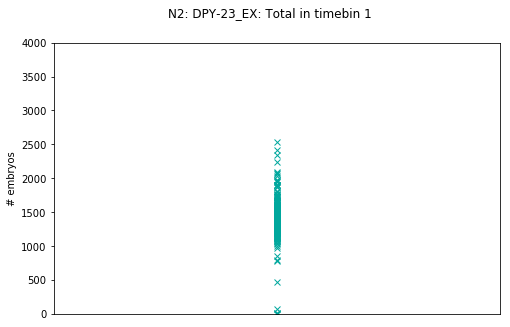

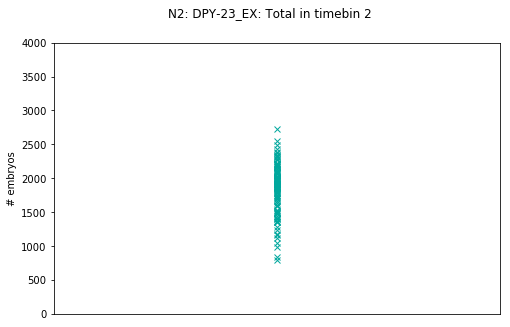

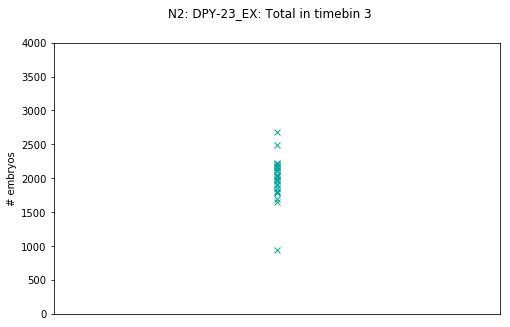

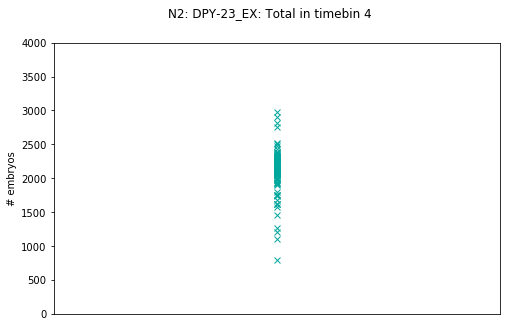

DOGE!


In [74]:
# IMPORTANT: KEEP THIS ONE! YOU WILL NEED IT LATER

# grab # nuclei 
# grab # of smfish
num_rows = df.shape[0]
num_timeframes = 4

x_pos = 10;

for t in range (0, num_timeframes):    
    result_set = []
    for j in range(0, num_rows):
        try: 
            # grab: 
            # - current timeframe
            # - correct gene 
            if (not np.isnan(df['#nuclei'][j])):
                if (df['#nuclei'][j] == (t + 1)):
                    for k in range(0, len(type_columns)): # over experiments
                        if (df[type_columns[k]][j] == stain[0]): 
                            if (not np.isnan(df[smfish_columns[k]][j])):
                                result_set.append(df[smfish_columns[k]][j])
                                # add picture to the image;
                                # print(stain[1], t + 1, df[smfish_columns[k]][j])
                            break
        except(RuntimeError, TypeError, ValueError, StopIteration):
        # except(ValueError):
            print("There was an exception but we\'ll fix it for you")
    # print(result_set)
    # plot here
    
    x = np.ones(len(result_set))*x_pos # + np.random.random(len(result_set))
    
    fig = plt.figure(figsize=(8,5))
    fig.suptitle("N2: " + stain[0] + ": Total in timebin " + str(t + 1))
    plt.plot(x, result_set, 'x', color=color)
    
    # TODO: remove the widefile images 
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    
    plt.ylim([-10, 4000])

    # plt.xlabel("# spots")
    plt.ylabel("# embryos")

    # df_center = pd.DataFrame(list(result_set.items()), columns=['filename', 'total'])
    # if not os.path.exists(folder_path):
    #     os.makedirs(folder_path )
    # df_center.to_csv(folder_path + labels[0] +"-total.csv", index=False, header=True, encoding='utf-8', mode = 'w' )
    if not os.path.exists(folder + "spread/"):
        os.makedirs(folder + "spread/")
    plt.savefig(folder + "spread/" + labels[0] + "-" + str(t + 1) + "-stage-spread.pdf") 
    plt.show()

print ("DOGE!") 

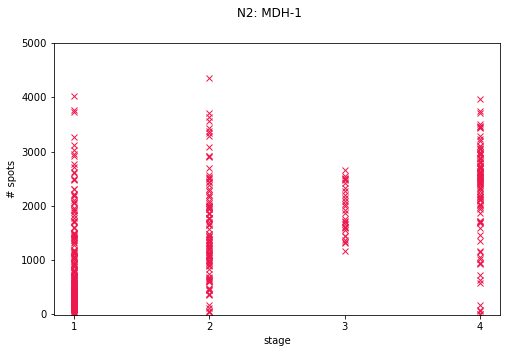

DOGE!


In [81]:
# IMPORTANT: KEEP THIS ONE! YOU WILL NEED IT LATER

# grab # nuclei 
# grab # of smfish
num_rows = df.shape[0]
num_timeframes = 4

fig = plt.figure(figsize=(8,5))
fig.suptitle("N2: " + stain[1])

for t in range (0, num_timeframes):    
    result_set = []
    for j in range(0, num_rows):
        try: 
            # grab: 
            # - current timeframe
            # - correct gene 
            if (not np.isnan(df['#nuclei'][j])):
                if (df['#nuclei'][j] == (t + 1)):
                    for k in range(0, len(type_columns)): # over experiments
                        if (df[type_columns[k]][j] == stain[1]): 
                            if (not np.isnan(df[smfish_columns[k]][j])):
                                result_set.append(df[smfish_columns[k]][j])
                                # add picture to the image;
                                # print(stain[1], t + 1, df[smfish_columns[k]][j])
                            break
        except(RuntimeError, TypeError, ValueError, StopIteration):
        # except(ValueError):
            print("There was an exception but we\'ll fix it for you")
    # print(result_set)
    # plot here
    
    x_pos = t + 1;
    
    x = np.ones(len(result_set))*x_pos # + np.random.random(len(result_set))
    
#     fig = plt.figure(figsize=(8,5))
#     fig.suptitle("N2: " + stain[1] + ": Total in timebin " + str(t + 1))
    plt.plot(x, result_set, 'x', color=color)
    
    # TODO: remove the widefile images 
#     plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)
    plt.xticks([1,2,3,4])
    
    plt.ylim([-10, 5000])

    plt.xlabel("stage")
    plt.ylabel("# spots")

    # df_center = pd.DataFrame(list(result_set.items()), columns=['filename', 'total'])
    # if not os.path.exists(folder_path):
    #     os.makedirs(folder_path )
    # df_center.to_csv(folder_path + labels[0] +"-total.csv", index=False, header=True, encoding='utf-8', mode = 'w' )
if not os.path.exists(folder + "spread/"):
    os.makedirs(folder + "spread/")
plt.savefig(folder + "spread/" + labels[0] + "-" + str(t + 1) + "-stage-spread-all.pdf") 
plt.show()

print ("DOGE!") 

In [56]:
print(stain[0], labels[0])
df[type_columns[1]][300]

DPY-23_EX MDH-1


'MDH-1'

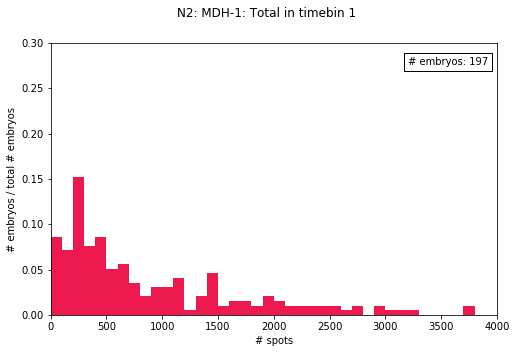

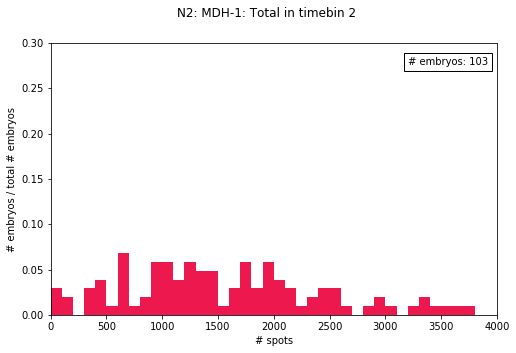

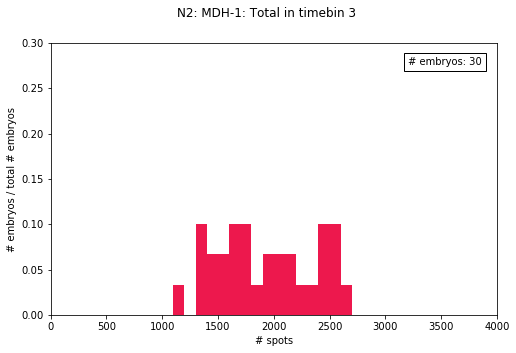

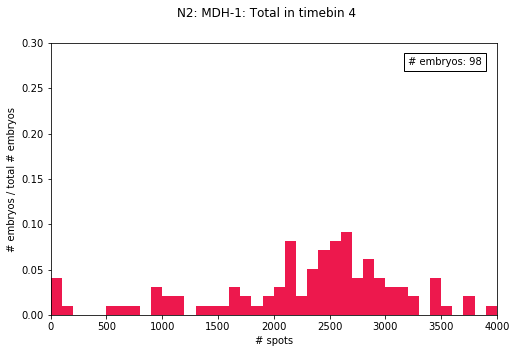

DOGE!


In [34]:
# grab # nuclei 
# grab # of smfish
num_rows = df.shape[0]
num_timeframes = 4

x_pos = 10;

for t in range (0, num_timeframes):    
    result_set = []
    for j in range(0, num_rows):
        try: 
            # grab: 
            # - current timeframe
            # - correct gene 
            if (not np.isnan(df['#nuclei'][j])):
                if (df['#nuclei'][j] == (t + 1)):
                    for k in range(0, len(type_columns)): # over experiments
                        if (df[type_columns[k]][j] == stain[1]): 
                            if (not np.isnan(df[smfish_columns[k]][j])):
                                result_set.append(df[smfish_columns[k]][j])
                                # add picture to the image;
                                # print(stain[1], t + 1, df[smfish_columns[k]][j])
                            break
        except(RuntimeError, TypeError, ValueError, StopIteration):
            print("There was an exception but we\'ll fix it for you")     
    # these are subject to change
    xmin = 0
    xmax = 4000
    
    binwidth = 100
    
    # total number of spots in all embryos per one timebin (stage)
    # normalization seems fine
    # print ("1.0 ?=", np.sum ( (result_set*binwidth) / np.sum(result_set*binwidth) ))
    # print ((result_set*binwidth) / np.sum(result_set*binwidth) )
    
    num_bins = (xmax - xmin) / binwidth + 1;
    bins = np.arange(xmin, xmax + binwidth, binwidth)
    
    xlimits = [xmin, xmax]
    ylimits = [0, 0.30]

    fig = plt.figure(figsize=(8,5))
    fig.suptitle("N2: " + stain[1] + ": Total in timebin " + str(t + 1))
    
    # plt.hist( (result_set) / np.sum(result_set), bins=bins, color=color, label=labels, normed=False)
    
    axes = plt.gca()
    axes.set_xlim(xlimits)
    axes.set_ylim(ylimits)
    
    weights = np.ones_like(result_set)/len(result_set)    
    plt.plot();
    plt.hist(result_set, bins=bins, color=color, label=labels, weights=weights) # normed=True)
     
    plt.xlabel("# spots")
    plt.ylabel("# embryos / total # embryos")
    
    info_text = "# embryos: " + str(len(result_set))
    plt.text(xlimits[1]*0.8, ylimits[1]*0.92, info_text, color='black', bbox=dict(facecolor='white', alpha=1)) #, family='monospace')

#     df_center = pd.DataFrame(list(result_set.items()), columns=['filename', 'total'])
#     if not os.path.exists(folder_path):
#         os.makedirs(folder_path )
#     df_center.to_csv(folder_path + labels[0] +"-total.csv", index=False, header=True, encoding='utf-8', mode = 'w' )
    if not os.path.exists(folder + "stages/"):
         os.makedirs(folder + "stages/")
    plt.savefig(folder + "stages/" + labels[0] + "-" + str(t + 1) + "-stage-total.pdf") 

    plt.show()

print ("DOGE!") 